In [1]:
%%html
<h2>TensorFlow による推奨コーディングの作法</h2>
<ul>
  <li>Inference : 「推論」に該当する部分。入力から、分類結果や回帰結果を予想する部分。</li>
  <li>Loss : 「目標値との誤差」に該当する部分。最適化したい値。→　Adadelta　使用</li>
  <li>Training: 最適化のアルゴリズム。</li>
</ul>

In [2]:
import numpy as np
import tensorflow as tf
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

np.random.seed(0)
tf.set_random_seed(1234)

# 推論部
#  x : データテンソル
#  keep_prob : ドロップアウトしない率
#  n_in : 入力次元数
#  n_hiddens : 隠れ次元数のリスト
#  n_out : 出力次元数
def inference(x, keep_prob, n_in, n_hiddens, n_out):
    # 重みの初期化
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01)
        return tf.Variable(initial)

    def bias_variable(shape):
        initial = tf.zeros(shape)
        return tf.Variable(initial)

    # 入力層 - 隠れ層、隠れ層 - 隠れ層
    for i, n_hidden in enumerate(n_hiddens):
        if i == 0:
            input = x
            input_dim = n_in
        else:
            input = output
            input_dim = n_hiddens[i-1]

        W = weight_variable([input_dim, n_hidden])
        b = bias_variable([n_hidden])

        h = tf.nn.relu(tf.matmul(input, W) + b)
        output = tf.nn.dropout(h, keep_prob)

    # 隠れ層 - 出力層
    W_out = weight_variable([n_hiddens[-1], n_out])
    b_out = bias_variable([n_out])
    y = tf.nn.softmax(tf.matmul(output, W_out) + b_out)
    return y

# 誤差関数
def loss(y, t):
    cross_entropy = \
        tf.reduce_mean(-tf.reduce_sum(
                       t * tf.log(tf.clip_by_value(y, 1e-10, 1.0)),
                       reduction_indices=[1]))
    return cross_entropy

# 最適化学習部
def training(loss):
#    optimizer = tf.train.GradientDescentOptimizer(0.01)
#    optimizer = tf.train.AdagradOptimizer(0.01)
    optimizer = tf.train.AdadeltaOptimizer(learning_rate=1.0, rho=0.95)
    train_step = optimizer.minimize(loss)
    return train_step

# 検証
def accuracy(y, t):
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy



'''
データの生成
'''
mnist = datasets.fetch_mldata('MNIST original', data_home='.')

n = len(mnist.data)
N = 30000  # MNISTの一部を使う
N_train = 20000
N_validation = 4000
indices = np.random.permutation(range(n))[:N]  # ランダムにN枚を選択

X = mnist.data[indices]
y = mnist.target[indices]
Y = np.eye(10)[y.astype(int)]  # 1-of-K 表現に変換

X_train, X_test, Y_train, Y_test = \
    train_test_split(X, Y, train_size=N_train)

X_train, X_validation, Y_train, Y_validation = \
    train_test_split(X_train, Y_train, test_size=N_validation)

'''
モデル設定
'''
n_in = len(X[0])
n_hiddens = [200, 200, 200]  # 各隠れ層の次元数
n_out = len(Y[0])
p_keep = 0.5

x = tf.placeholder(tf.float32, shape=[None, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
keep_prob = tf.placeholder(tf.float32)

y = inference(x, keep_prob, n_in=n_in, n_hiddens=n_hiddens, n_out=n_out)
loss = loss(y, t)
train_step = training(loss)

accuracy = accuracy(y, t)

history = {
    'val_loss': [],
    'val_acc': []
}

'''
モデル学習
'''
epochs = 50
batch_size = 200

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

n_batches = N_train // batch_size

for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train)

    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size

        sess.run(train_step, feed_dict={
            x: X_[start:end],
            t: Y_[start:end],
            keep_prob: p_keep
        })

    # 検証データを用いた評価
    val_loss = loss.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation,
        keep_prob: 1.0
    })
    val_acc = accuracy.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation,
        keep_prob: 1.0
    })

    # 検証データに対する学習の進み具合を記録
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print('epoch:', epoch,
          ' validation loss:', val_loss,
          ' validation accuracy:', val_acc)

'''
予測精度の評価
'''
accuracy_rate = accuracy.eval(session=sess, feed_dict={
    x: X_test,
    t: Y_test,
    keep_prob: 1.0
})
print('accuracy: ', accuracy_rate)

epoch: 0  validation loss: 0.43036  validation accuracy: 0.85375
epoch: 1  validation loss: 0.276997  validation accuracy: 0.922
epoch: 2  validation loss: 0.2229  validation accuracy: 0.93475
epoch: 3  validation loss: 0.201239  validation accuracy: 0.9425
epoch: 4  validation loss: 0.185459  validation accuracy: 0.94925
epoch: 5  validation loss: 0.176887  validation accuracy: 0.952
epoch: 6  validation loss: 0.171255  validation accuracy: 0.9555
epoch: 7  validation loss: 0.165096  validation accuracy: 0.9565
epoch: 8  validation loss: 0.161599  validation accuracy: 0.95675
epoch: 9  validation loss: 0.164705  validation accuracy: 0.956
epoch: 10  validation loss: 0.16709  validation accuracy: 0.95925
epoch: 11  validation loss: 0.164078  validation accuracy: 0.9595
epoch: 12  validation loss: 0.162198  validation accuracy: 0.95925
epoch: 13  validation loss: 0.161704  validation accuracy: 0.9605
epoch: 14  validation loss: 0.169617  validation accuracy: 0.95825
epoch: 15  validatio

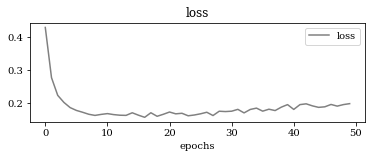

In [3]:
'''
学習の進み具合を可視化
'''
plt.rc('font', family='serif')
fig = plt.figure()
plt.subplot(2, 1, 1)
#plt.plot(range(epochs), history['val_acc'], label='acc', color='black')
plt.plot(range(epochs), history['val_loss'], label='loss', color='gray')

plt.title('loss')
plt.xlabel('epochs')
plt.legend(loc='best')
plt.show()

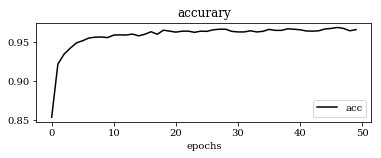

In [4]:
plt.rc('font', family='serif')
plt.subplot(2, 1, 2)
plt.plot(range(epochs), history['val_acc'], label='acc', color='black')

plt.title('accurary')
plt.xlabel('epochs')
plt.legend(loc='best')
plt.show()